<a href="https://colab.research.google.com/github/LokiAndere/MIARFID-VPC-2019-20/blob/master/bilinearapproach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import print_function

import keras

from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input,decode_predictions

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Lambda
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization as BN
from keras.layers import GaussianNoise as GN
from keras.optimizers import SGD
from keras.models import Model
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

from keras.callbacks import LearningRateScheduler as LRS
from keras.preprocessing.image import ImageDataGenerator

from keras import backend


In [0]:
os.system('wget https://www.dropbox.com/s/sakfqp6o8pbgasm/data.tgz')
os.system('tar xvzf data.tgz')

0

In [0]:
batch_size = 50
num_classes = 20
epochs = 150

(791, 250, 250, 3)
(791,)
(784, 250, 250, 3)
(784,)


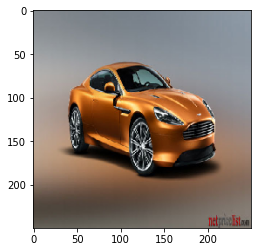

In [88]:
# Load 
x_train = np.load('x_train.npy')
x_test = np.load('x_test.npy')

y_train = np.load('y_train.npy')
y_test = np.load('y_test.npy')

# Stats
print(x_train.shape)
print(y_train.shape)

print(x_test.shape)
print(y_test.shape)

## View some images
plt.imshow(x_train[69,:,:,: ] )
plt.show()

In [0]:
## Transforms
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

y_train = y_train.astype('float32')
y_test = y_test.astype('float32')


x_train /= 255
x_test /= 255


## Labels
y_train=y_train-1

y_test=y_test-1

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [100]:
#backend.clear_session()

modelA=VGG16(weights='imagenet', include_top=False)

for i, layer in enumerate(modelA.layers):
    if i<9:
      a = '_A0'
    else:
      a = '_A'
    layer.name = layer.name + a + str(i+1)
    layer.trainable = True
modelA.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6_A01 (InputLayer)     (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1_A02 (Conv2D)    (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2_A03 (Conv2D)    (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool_A04 (MaxPooling2 (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1_A05 (Conv2D)    (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2_A06 (Conv2D)    (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool_A07 (MaxPooling2 (None, None, None, 128)   0     

In [101]:
#backend.clear_session()

modelB=VGG16(weights='imagenet', include_top=False)

for i, layer in enumerate(modelB.layers):
    if i<9:
      a = '_B0'
    else:
      a = '_B'
    layer.name = layer.name + a + str(i+1)
    layer.trainable = True

modelB.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7_B01 (InputLayer)     (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1_B02 (Conv2D)    (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2_B03 (Conv2D)    (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool_B04 (MaxPooling2 (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1_B05 (Conv2D)    (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2_B06 (Conv2D)    (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool_B07 (MaxPooling2 (None, None, None, 128)   0     

In [102]:

#############################
###      BILINEAR        ####
#############################

def outer_product(x):
  phi_I = tf.einsum('ijkm,ijkn->imn',x[0],x[1])		# Einstein Notation  [batch,1,1,depth] x [batch,1,1,depth] -> [batch,depth,depth]
  phi_I = tf.reshape(phi_I,[-1,512*512])	        # Reshape from [batch_size,depth,depth] to [batch_size, depth*depth]
  phi_I = tf.divide(phi_I,3*3)								  # Divide by feature map size [sizexsize]

  y_ssqrt = tf.multiply(tf.sign(phi_I),tf.sqrt(tf.abs(phi_I)+1e-12))		# Take signed square root of phi_I
  z_l2 = tf.nn.l2_normalize(y_ssqrt)								              # Apply l2 normalization
  return z_l2

d1=modelA.layers[-1].output
d2=modelB.layers[-1].output

x = Lambda(outer_product, name='outer_product')([d1,d2])

predictions=Dense(num_classes, activation='softmax', name='predictions')(x)
tog=[modelA.input,modelB.input]
model = Model(inputs=tog, outputs=predictions)
  
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6_A01 (InputLayer)        (None, None, None, 3 0                                            
__________________________________________________________________________________________________
input_7_B01 (InputLayer)        (None, None, None, 3 0                                            
__________________________________________________________________________________________________
block1_conv1_A02 (Conv2D)       (None, None, None, 6 1792        input_6_A01[0][0]                
__________________________________________________________________________________________________
block1_conv1_B02 (Conv2D)       (None, None, None, 6 1792        input_7_B01[0][0]                
____________________________________________________________________________________________

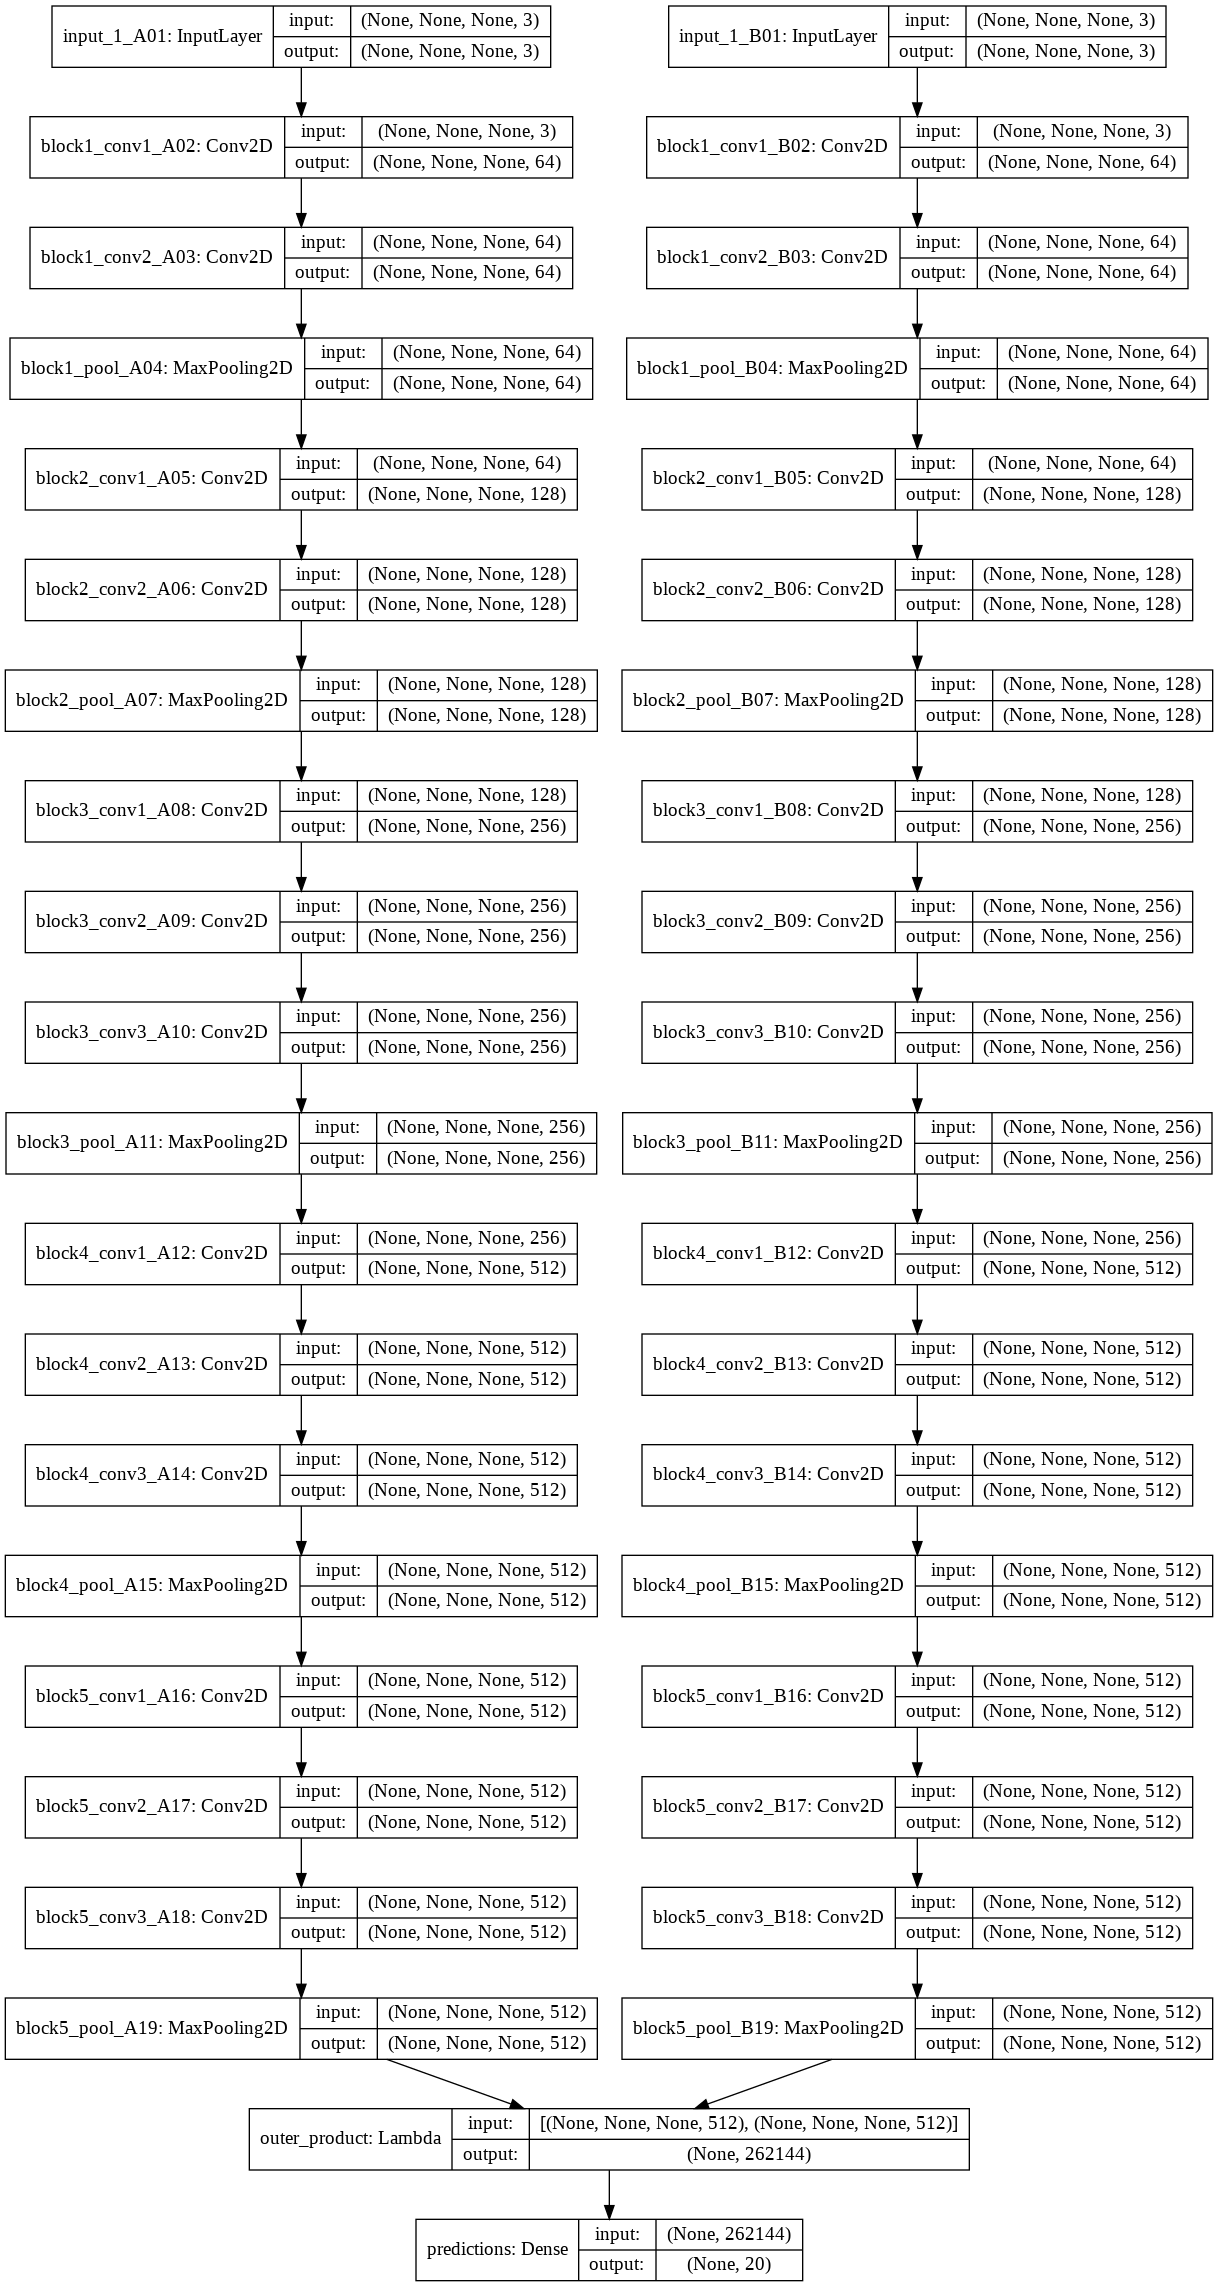

In [0]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [0]:
## OPTIM AND COMPILE
opt = SGD(lr=0.1, decay=1e-6)

model1.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

# DEFINE A LEARNING RATE SCHEDULER
def scheduler(epoch):
    if epoch < 25:
        return .1
    elif epoch < 50:
        return 0.01
    else:
        return 0.001

set_lr = LRS(scheduler)

datagen = ImageDataGenerator(
  rotation_range=20.0,
  width_shift_range=0.2,
  height_shift_range=0.2,
  zoom_range=[1.0,1.2],
  horizontal_flip=True)

def two_datagen(generator, x, y, batch_sizes):
    genX = generator.flow(x, seed=7, batch_size=batch_size)
    genY = generator.flow(y, seed=7, batch_size=batch_size)
    while True:
      yi = genY.next()
      xi = genX.next()
      xi2 = function(x)
      yield [xi,xi2],yi

def two_datagen2(generator, x, y, batch_sizes):
    genX = generator.flow(x, y,seed=7,batch_size=batch_sizes)
    #genY = generator.flow(y, seed=7, batch_size=batch_size)
    while True:
      #yi = genX.next()
      [xi,yi] = genX.next()
      #xi2 = function(x)
      yield [xi,xi],yi

In [148]:
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
    
  




## TRAINING with DA and LRA
history=model.fit_generator(two_datagen2(datagen,x_train, y_train,batch_size),
                            steps_per_epoch=len(x_train) / batch_size, 
                            epochs=epochs,
                            validation_data=([x_test, x_test], y_test),
                            callbacks=[set_lr],
                            verbose=1)

Epoch 1/150
16/15 [==============================] - 24s 1s/step - loss: 2.9952 - accuracy: 0.0405 - val_loss: 2.9936 - val_accuracy: 0.0587
Epoch 2/150
16/15 [==============================] - 20s 1s/step - loss: 2.9944 - accuracy: 0.0582 - val_loss: 2.9928 - val_accuracy: 0.0587
Epoch 3/150
16/15 [==============================] - 20s 1s/step - loss: 2.9936 - accuracy: 0.0582 - val_loss: 2.9922 - val_accuracy: 0.0587
Epoch 4/150
16/15 [==============================] - 20s 1s/step - loss: 2.9931 - accuracy: 0.0582 - val_loss: 2.9916 - val_accuracy: 0.0587
Epoch 5/150
16/15 [==============================] - 20s 1s/step - loss: 2.9927 - accuracy: 0.0582 - val_loss: 2.9912 - val_accuracy: 0.0587
Epoch 6/150
16/15 [==============================] - 21s 1s/step - loss: 2.9922 - accuracy: 0.0582 - val_loss: 2.9908 - val_accuracy: 0.0587
Epoch 7/150
16/15 [==============================] - 21s 1s/step - loss: 2.9916 - accuracy: 0.0582 - val_loss: 2.9904 - val_accuracy: 0.0587
Epoch 8/150
1